In [1]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=cd5f039ae32cbc86ff956b77fb3bd3dcd1ffc3272b2f150528562d4d18ebe5f0
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [10]:
################################
###  Read Passwords Dataset  ###
################################

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/Shareddrives/ENLP Final Projects - Passwords/autoencoder/"

passwords = pd.read_csv(path + "data/1000passwords.csv", dtype={'Numeric': str})
print(passwords)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    Capital   Word Numeric Special FullPassword
0         A   cafe    2019       !   Acafe2019!
1         A  hyper    2019       !  Ahyper2019!
2         P   leet      10       !     Pleet10!
3         A   babe       2       !      Ababe2!
4         T  bingo    1234       *  Tbingo1234*
..      ...    ...     ...     ...          ...
995       A   leet     123       !    Aleet123!
996       A  hyper     777       !   Ahyper777!
997       P   cafe     123       *    Pcafe123*
998       A   cafe      10       %     Acafe10%
999       A   babe     101       _    Ababe101_

[1000 rows x 5 columns]


In [3]:
##################################
###  Pad & Tokenize Passwords  ###
##################################
from keras.utils import to_categorical
from keras.preprocessing import sequence

# Identify max password length in dataset and pad rest of the passwords such that all of them have the same length.
# Haveing same length sequences is a requirement for LSTM
PAD_CHAR = "~"
PASS_LENGTH = max([len(p) for p in passwords["FullPassword"]])

padded_passwords = []
charset = set(PAD_CHAR)               # start with the initial padding char
for p in passwords["FullPassword"]:
  padded_passwords.append(p.ljust(PASS_LENGTH, PAD_CHAR))
  charset |= set(p)                   # |= is the union set operation.

# Convert characters to integers 
vocab_size = len(charset)
char2id = dict((c, i) for i, c in enumerate(charset))

# One hot encode the passwords
encoded_passwords = [[char2id[c] for c in password] for password in padded_passwords]
one_hot_encoded = np.array([to_categorical(p, num_classes=vocab_size) for p in encoded_passwords])

print("Pass length: " + str(PASS_LENGTH))
print("Vocab size: " + str(vocab_size))
print("Encoded passwords shape: " + str(np.shape(encoded_passwords)))
print("One-hot encoded passwords shape: " + str(np.shape(encoded_passwords)))

Pass length: 15
Vocab size: 38
Encoded passwords shape: (1000, 15)
One-hot encoded passwords shape: (1000, 15)


# Standard Autoencoders

In [4]:
##################################
###  Create Autoencoder Model  ###
##################################
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Bidirectional
from keras.models import Model

def create_lstm_autoencoder(timesteps, layer_sizes, vocab_size):
  """
  Creates a symmetric LSTM autoencoder model and returns, the autoencoder model, encoder model,
  and decoder model to be used individually.
  """
  # Create encoder model
  enc_input = Input(shape=(timesteps, vocab_size))
  x = enc_input
  for idx, layer_size in enumerate(layer_sizes):
    ret_seq = (idx != len(layer_sizes) - 1) # False for the last layer_size
    x = Bidirectional(LSTM(layer_size, return_sequences=ret_seq))(x)
  enc_output = Dense(layer_sizes[-1], activation="relu")(x)
  encoder = Model(enc_input, enc_output, name="Encoder")

  # Create decoder model
  bottleneck_size = layer_sizes[-1]
  dec_input = Input((bottleneck_size,))
  x = RepeatVector(timesteps)(dec_input)
  for layer_size in layer_sizes[::-1][1:]:
    x = Bidirectional(LSTM(layer_size, return_sequences=True))(x)
  dec_output = TimeDistributed(Dense(vocab_size, activation="softmax"))(x)
  decoder = Model(dec_input, dec_output, name="Decoder")

  # Connect decoder with encoder
  connected_decoder = decoder(enc_output)

  # Create autoencoder model
  autoencoder = Model(enc_input, connected_decoder, name="Autoencoder")
  autoencoder.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
  return encoder, decoder, autoencoder

In [5]:
encoder, decoder, autoencoder = create_lstm_autoencoder(PASS_LENGTH, [16, 10, 6], vocab_size)
encoder.summary()
decoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 38)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 32)            7040      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 15, 20)            3440      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 12)                1296      
_________________________________________________________________
dense (Dense)                (None, 6)                 78        
Total params: 11,854
Trainable params: 11,854
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Sh

In [6]:
#####################
###  Train Model  ###
#####################

autoencoder.fit(one_hot_encoded, one_hot_encoded, epochs=300, batch_size=10)

Epoch 1/300
100/100 [==============================] - 42s 16ms/step - loss: 3.2998 - accuracy: 0.2999
Epoch 2/300
100/100 [==============================] - 2s 16ms/step - loss: 2.2936 - accuracy: 0.3960
Epoch 3/300
100/100 [==============================] - 2s 16ms/step - loss: 1.8810 - accuracy: 0.4775
Epoch 4/300
100/100 [==============================] - 2s 17ms/step - loss: 1.6451 - accuracy: 0.5052
Epoch 5/300
100/100 [==============================] - 2s 16ms/step - loss: 1.5032 - accuracy: 0.5311
Epoch 6/300
100/100 [==============================] - 2s 16ms/step - loss: 1.4187 - accuracy: 0.5388
Epoch 7/300
100/100 [==============================] - 2s 16ms/step - loss: 1.3372 - accuracy: 0.5627
Epoch 8/300
100/100 [==============================] - 2s 16ms/step - loss: 1.2787 - accuracy: 0.5822
Epoch 9/300
100/100 [==============================] - 2s 16ms/step - loss: 1.1982 - accuracy: 0.6193
Epoch 10/300
100/100 [==============================] - 2s 17ms/step - loss: 1.14

In [7]:
# Recosntruct passwords through autoencoder as vectors
reconst_passwd_vecs = autoencoder.predict(one_hot_encoded)
# Reverse one hot encoding to covnert passwords to strings
unpad = lambda text: text.replace(PAD_CHAR, "")
one_hot_decode = lambda one_hot_vectors: "".join([list(charset)[np.argmax(vec)] for vec in one_hot_vectors])
reconst_passwd_str = [unpad(one_hot_decode(p)) for p in reconst_passwd_vecs]

In [8]:
# Compare original vs reconstructed passwords
passwords_df = pd.DataFrame(zip(passwords["FullPassword"], reconst_passwd_str),
                            columns = ['Original Password', 'Recosntructed Password'])
passwords_df.head(10)

,Original Password,Recosntructed Password
0,Acafe2019!,Acafe2019!
1,Ahyper2019!,Ahyper2019!
2,Pleet10!,Pleet10!
3,Ababe2!,Ababe2!
4,Tbingo1234*,Tbingo1234*
5,Eleet2019@,Eleet2019@
6,Tninja123!,Pninja123!
7,Aninja777*,Aninja777*
8,Ababe101*,Ababe101*
9,Tbingo2019_,Tbingo2019@


In [11]:
################################
###  Generate New Passwords  ###
################################
import random

# Feel free to change the latent space values as you like and explore what comes
# out from the decoder
new_passwords = []
for _ in range(20):
  latent_sample = np.array([[random.uniform(-1, 1) for _ in range(6)]])
  new_password_vec = decoder.predict(latent_sample)
  new_password_str = unpad(one_hot_decode(new_password_vec[0]))
  new_passwords.append(new_password_str)
new_passwords_df = pd.DataFrame(new_passwords, columns=["Password"])

# Save them into a CSV file
new_passwords_df.to_csv(path + 'data/output/ae_sample_pass.csv', sep=',')

new_passwords_df.head(10)

,Password
0,Alcckrrrell
1,kkkkkkkkkmAAAl!
2,yyyhhhhhhhhcccc
3,2222222222222TP
4,Alaackkkkkk!ll
5,kkkkkkkkkkkkkke
6,Aaakkrmmmalll
7,Acafe7777!
8,Alccee77e
9,kkkkkjjjjmmmmkk


In [12]:
#######################################
###  Calcualte the Average Entropy  ###
#######################################
!pip install BiEntropy

from bientropy import bien, tbien

sum_entropy = 0
max_entropy = float('-inf')
min_entropy = float('inf')

for pswd in new_passwords:
  pswd_bytes = bytes(pswd, 'utf-8')
  e = tbien(pswd_bytes)
  sum_entropy += e
  # update the max and the min entropy
  max_entropy = max(max_entropy, e)
  min_entropy = min(min_entropy, e)

avg_entropy = sum_entropy / len(new_passwords)

print("MAX entropy: " + str(max_entropy))
print("MIN entropy: " + str(min_entropy))
print("AVG entropy: " + str(avg_entropy))

     |████████████████████████████████| 163kB 27.8MB/s 
     |████████████████████████████████| 204kB 42.0MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-cp37-none-any.whl size=37949 sha256=6ce703089d577f4ca9e650d9e8464ee2df9f88b9ff7fd02bb64155eb828aab23
  Stored in directory: /root/.cache/pip/wheels/b8/27/f0/8373e26b7de57db03dc18aaaebdd8c26a99da882416f762979
Successfully built bitstring
MAX entropy: 0.965385345269509
MIN entropy: 0.40535404396816216
AVG entropy: 0.8313206803569173


Plotting t-SNE visualization...


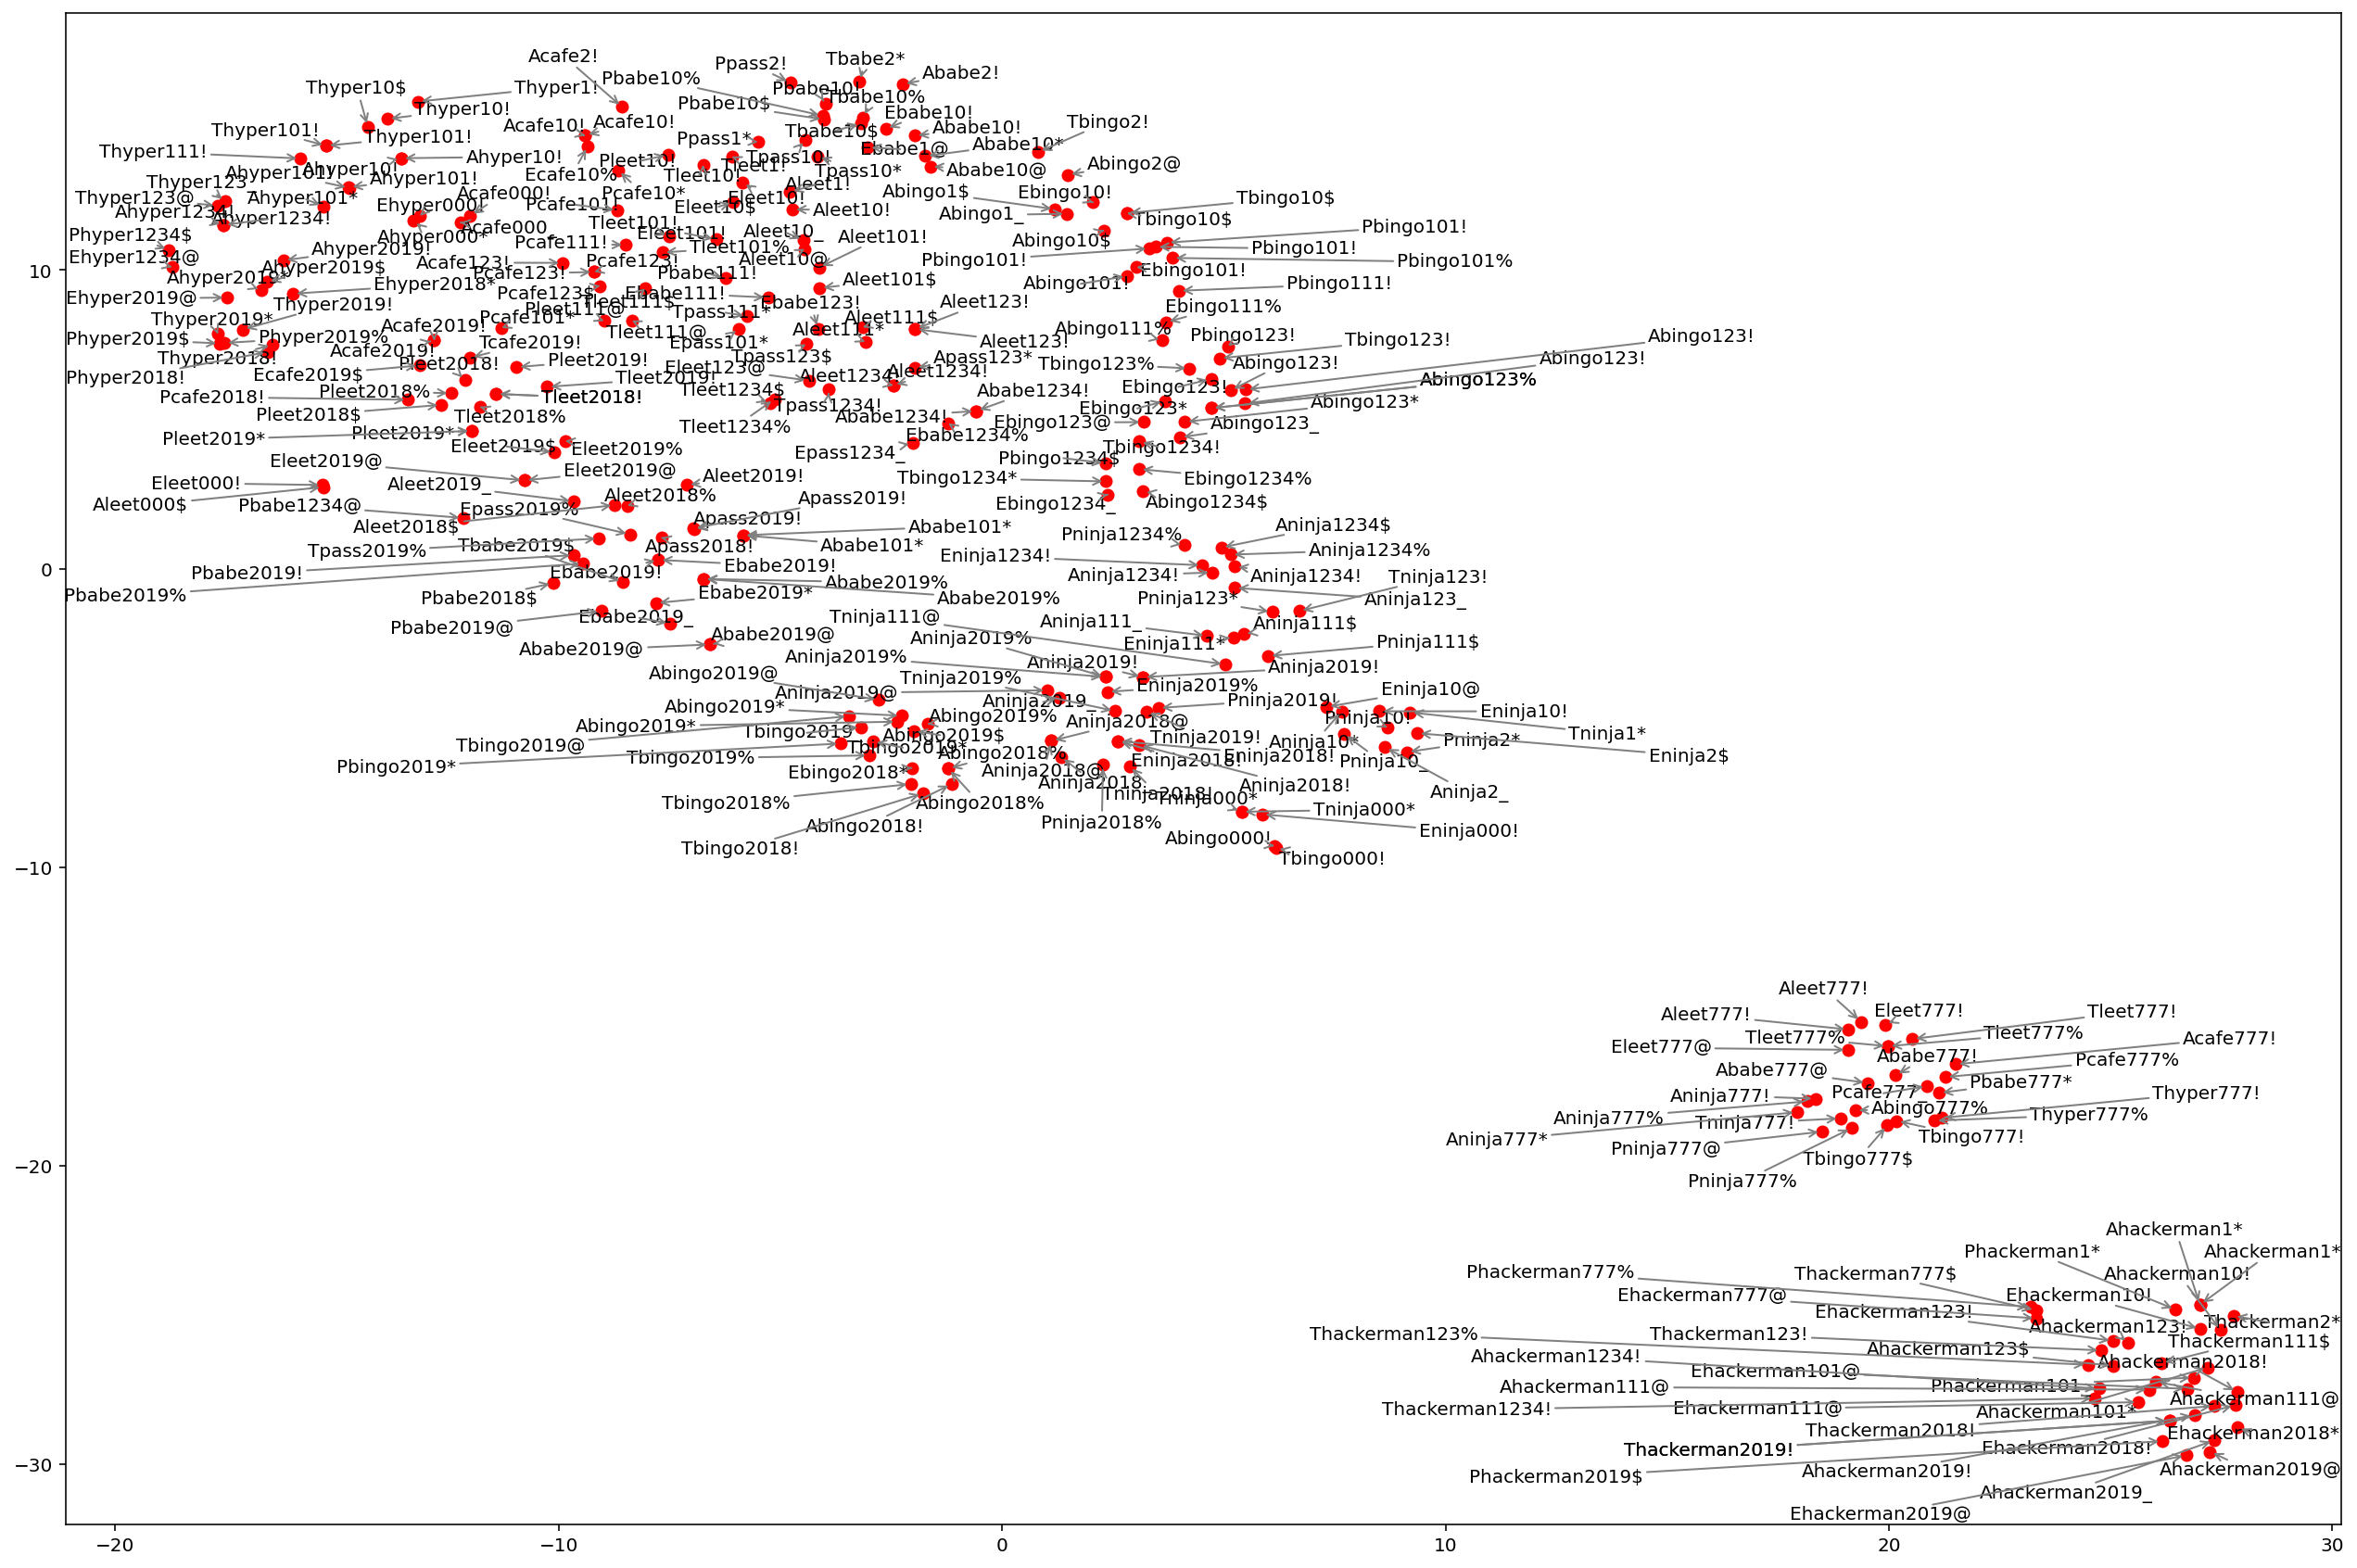

In [13]:
#############################################
###  Visualize Passowrds in Latent Space  ###
#############################################
%config InlineBackend.figure_format = 'retina'

from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox
from sklearn import manifold

def t_sne(latent_passwords, original_passwords, plot=True):
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(latent_passwords)
    if plot:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(22,15))
        plt.plot(X_tsne[:, 0], X_tsne[:, 1], 'ro')
        texts = [plt.text(X_tsne[:, 0][i], X_tsne[:, 1][i], '%s' %original_passwords[i], ha='center', va='center') for i in range(len(original_passwords))]
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
        plt.show()
    else:
        return X_tsne, tsne

limit = 300
latent_passwords = encoder.predict(one_hot_encoded[:limit])
t_sne(latent_passwords, passwords["FullPassword"][:limit])